## NERD-BOT: Agente de reinforcement learning para acomodar tu plan de estudios.

La idea es implementar un modelo de reinforcement learning para optimizar la eleccion de materias por cuatrimestre, en funcion al horario, correlatividad y demas factores.

Utilidad -> Particularmente para casos con cambio de plan de estudio, con la carrera en curso o tener mas carreras en simultaneo.

### IDEA: < imagen >

La idea es que funcione siguiendo el modelo de decision de Markov (PDM):

### Funcionamiento PDM: < imagen >

Donde $\phi(s,a)$ es la recompensa de hacer $a$ desde el state $s$.

Por la ecuacion de Bellman queda:

$\phi(s,a)=R(s)+\alpha\max{a´} \phi(s´,a´)$ 

### Cantidad de P acciones posibles, dadas m materias restantes

Hay $P(m)$ combinaciones posibles de ordenar por cuatrimestre $m$ materias restantes por cursar en el state $s$ : $L_s$ = {$M_1$, ..., $M_m$}

Es decir, a priori $P(m)$ es el numero de caminos posibles a tener en consideracion en el computo*.

En particular, 

> $P(0) = 0, P(1) = 1, P(m)=\sum_{i=1}^{m}(\binom{m}{i}+P(m-i))$

*Obs: Esta aproximacion excluye restricciones en las m materias por correlatividad.


In [2]:
def P(m) -> int:
    if m in [0,1]:
        return m
    else: 
        return sum([(nC(m, i+1) + P(m-(i+1))) for i in range(m)])

def nC (n, k) -> int:
    # numero combinatorio
    return (factorial(n) / (factorial(k) * factorial(n-k)))

def factorial (n) -> int:
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)

Veo grafico comparativo de como escala la cantidad de computo por materias a ordenar

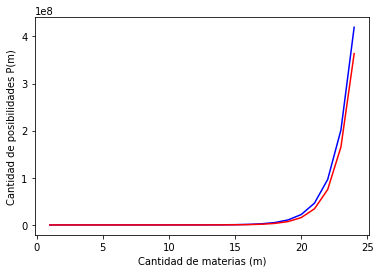

In [3]:
import matplotlib.pyplot as plt

rango_m = list(range(1,25))
Y = [P(i+1) for i in rango_m]

# f ejemplo para comparar tipo de escalamiento del computo en P(m) 
f = lambda i: (2.2)**i

plt.plot(rango_m, Y, color="blue")
plt.plot(rango_m, [f(i+1) for i in rango_m], color="red")
plt.xlabel("Cantidad de materias (m)")
plt.ylabel("Cantidad de posibilidades P(m)")
plt.show()

### Problem Classes

In [33]:
class Materia ():
    def __init__ (self, nombre, horas_por_semana, requirements=[]):
        self.nombre = nombre
        self.horas_por_semana = horas_por_semana
        self.requirements = requirements # materias necesarias para cursar

    def __str__ (self):
        return self.nombre

class Cuatrimestre ():
    def __init__ (self, materias, year, n_cuatrim):
        self.materias = materias
        self.year = year
        self.n_cuatr = n_cuatrim
    
    def get_date_info(self):
        return self.year, self.n_cuatr

class PlanDeEstudios ():
    def __init__ (self, titulo:str, tipo:str,
                  json_data:dict, reward:int):
        self.materias = []
        for cuatrim in json_data:
            self.materias += json_data[cuatrim] 
        self.tipo = tipo
        self.titulo = titulo
        self.reward = reward

### Reinforcement Learning Classes

In [2]:
def all_combinations (ls:list) -> list:
    """ 
    Receives a list of elements and returns another list of lists 
    with all the possible manners to pick elements from the original one.
    
    It works recursively, adding all_combs of tail list with the sum of 
    fst element to all_combs of tail list.

    Parameters:
        ls: List<Obj>
    
    Returns List<List<Obj>>
    """
    if len(ls) == 0:
        return [[]]
    elif len(ls) == 1:
        return [[], [ls[0]]]
    else:
        lst_combs = all_combinations(ls[:-1])
        return lst_combs + [c+[ls[-1]] for c in lst_combs]

class State ():
    # state de materias cursadas y por cursar
    def __init__ (self, cuatrimestres_cursados:list(), materias_por_cursar:list()):
        self.cuatrimestres_cursados = cuatrimestres_cursados
        self.materias_cursadas = []
        for cuatr in cuatrimestres_cursados:
            self.materias_cursadas += cuatr.materias # lista de materias
        self.materias_por_cursar = materias_por_cursar
        ult_cuatr = self.cuatrimestres_cursados[-1]
        self.fecha_ultimo_cuatrimestre = (ult_cuatr.year, ult_cuatr.n_cuatr)

    def possible_actions(self) -> list:
        materias_a_combinar = self.filtrar_por_correlatividad(
                    self.materias_cursadas,
                    self.materias_por_cursar
        )
        # pruebo eliminar el caso que se elige no estudiar nada
        return all_combinations(materias_a_combinar)[1:] 
        
    def filtrar_por_correlatividad(self, materias_cursadas,
                                         _materias_por_cursar) -> list:
        for materia in _materias_por_cursar:
            if materia.requirements in materias_cursadas:
                _materias_por_cursar.remove(materia)
        return _materias_por_cursar

    def __str__ (self):
        return (f"state:\nmaterias_cursadas: {[m.nombre for m in self.materias_cursadas]} "+ 
                 f"\nmaterias_por_cursar: {[m.nombre for m in self.materias_por_cursar]}")

class Environment ():
    # materias disponibles
    def __init__ (self, init_state):
        self.state = init_state

    def in_end_state (self):
        return len(self.state.possible_actions()) == 0

    def execute (self, materias_elegidas): # execute action
        """ 
        Updates materias_cursadas and materias_por_cursar adding/deleting selected \
        materias_elegidas.
        Parameters:
            materias_elegidas = List<Materias>
        """
        # agrego las materias estudiadas en el cuatrimestre a materias_cursadas
        # elimino las materias de las materias disponibles
        year, n_cuatr = self.state.fecha_ultimo_cuatrimestre
        for materia in materias_elegidas:
            self.state.materias_cursadas.append(materia)
            self.state.materias_por_cursar.remove(materia)
        return year, n_cuatr

In [85]:
class Agent ():
    def __init__ (self, alpha=0.5):
        self.alpha = alpha
        self.history = []
        self.career_plans = []

    def make_career_plan (self, initial_state) -> dict:
        """ 
        Returns a dict with the agents suggested career plan.
        Parameters:
            initial_state : State
        """
        environment = Environment(initial_state)
        while not environment.in_end_state():
            best_subjects = self.pick_best_action(environment.state) # state contiene metodo state.possible_actions()
            n_cuatr, year = environment.execute(best_subjects) # execute hace un environment.set_state(state')
            # hago un registro en la history del agent
            cuatrimestre = Cuatrimestre(best_subjects, n_cuatr, year)
            self.history.append(cuatrimestre)
        return self.pretty_print_history()

    def pretty_print_history(self):
        return {}

    def learn_career_plans (self, career_plans):
        self.career_plans = career_plans

    def R (self, state):
        """
        Returns a numerical reward from being in state s.
        Parameters:
            state : State
            (internal) planes_de_carrera
        """
        reward = 0
        for plan_de_carrera in self.career_plans:
            if plan_de_carrera.materias in state.materias_cursadas:
                reward += plan_de_carrera.reward
        return reward

    def Q (self, state, action):
        """
        Returns a numerical reward after applying action a from state s.
        Parameters:
            state : State
            action : List<Materias>
        """
        print (state)
        print ("action:",action)
        fake_env = Environment(state)
        fake_env.execute(action)
        post_action = self.pick_best_action(fake_env.state)
        return self.R(state) + self.alpha * self.Q(fake_env.state,post_action) 

    def pick_best_action (self, state):
        """ 
        Returns the suggested Cuatrimestre to study given a state.
        Parameters:
            state : State
        """
        possible_actions = state.possible_actions()
        if len(possible_actions) > 0:
            best_choice = (0, possible_actions[0])
            max = self.Q(state, possible_actions[0])
            for j, a_ in enumerate(possible_actions[1:]):
                val = self.Q(state, a_)
                if best_choice[1] >= max:
                    best_choice = (j, val)
            return best_choice
        return []

#### Hago un setup de las materias, sus relaciones y los planes de estudio

In [58]:
# MATERIAS 

AnalisisI = Materia("Analisis I", 10)
AnalisisII = Materia("Analisis II", 10, requirements=[AnalisisI])
IntroProgramacion = Materia("Introduccion Programacion", 10, requirements=[])
AED = Materia("Algoritmo y Estructura de Datos", 15, requirements=[IntroProgramacion])
Algebra = Materia("Algebra I", 13)
ALC = Materia("Algebra Lineal Computacional", 10, requirements=[Algebra, IntroProgramacion])
Paradigmas = Materia("Paradigmas de Programacion", 10, requirements=[AED])
TDA = Materia("Tecnicas de Diseño de Algoritmos", 10, requirements=[AED])
SD = Materia("Sistemas Digitales", 5, requirements=[IntroProgramacion])
IngSoft = Materia("Ingenieria en Software", 10, requirements=[Paradigmas])
LFAyC = Materia("Lenguajes Formales, Automatas y Computabilidad", 5, requirements=[AED])
AOC = Materia("Arquitectura y Organizacion de Computadores", 10, requirements=[SD])
Complej = Materia("Complejidad Computacional", 5, requirements=[TDA, LFAyC])
SO = Materia("Sistemas Operativos", 10, requirements=[AOC])
Estadistica = Materia("Estadistica Computacional", 10, requirements=[ALC, AnalisisI])
Info =  Materia("Almacenamiento y Recuperacion de la Informacion", 10, requirements=[IngSoft])
Redes = Materia("Redes de Comunicaciones y Computo Distribuido", 10, requirements=[Estadistica, TDA, SO])
Paralela = Materia("Programacion Concurrente y Paralela", 10, requirements=[SO, Paradigmas])

Optativa1 = Materia("Optativa1", 0)
Optativa2 = Materia("Optativa2", 0)
Optativa3 = Materia("Optativa3", 0)
Tesis = Materia("Tesis", 15, requirements=[Redes, Info, Paralela])

# PLANES DE ESTUDIO

REWARD_TITULO_INTERMEDIO = 50
REWARD_TITULO_GRADO = 100

LicenciadoCS = PlanDeEstudios("Licenciado Ciencias de la Computacion",
                              "Grado",
                              {
                                1: [Algebra, IntroProgramacion],
                                2: [AED, AnalisisI],
                                3: [Paradigmas, TDA, SD],
                                4: [IngSoft, LFAyC, AOC],
                                5: [ALC, Complej, SO],
                                6: [Estadistica, Info, Optativa1],
                                7: [Paralela, Redes, Optativa2],
                                8: [Tesis, Optativa3]
                              },
                              REWARD_TITULO_GRADO
                            )

IntermedioCS = PlanDeEstudios("Analista Ciencias de la Computacion",
                              "Intermedio",
                              {
                                1: [Algebra, IntroProgramacion],
                                2: [AED],
                                3: [Paradigmas, TDA, SD],
                                4: [IngSoft, AOC]
                              },
                              REWARD_TITULO_INTERMEDIO
                            )

LicenciadoDS = PlanDeEstudios("Licenciado Ciencia de Datos",
                              "Grado",
                              {
                                1: [Algebra, IntroProgramacion],
                                2: [AED, AnalisisI],
                                3: [Paradigmas, TDA, SD],
                                4: [IngSoft, LFAyC, AOC],
                                5: [ALC, Complej, SO],
                                6: [Estadistica, Info, Optativa1],
                                7: [Paralela, Redes, Optativa2],
                                8: [Tesis, Optativa3]
                              },
                              REWARD_TITULO_GRADO
                            )

IntermedioDS = PlanDeEstudios("Analista Ciencia de Datos",
                              "Intermedio",
                              {
                                1: [Algebra, IntroProgramacion],
                                2: [AED],
                                3: [Paradigmas, TDA, SD],
                                4: [IngSoft, AOC]
                              },
                              REWARD_TITULO_INTERMEDIO
                            )

In [86]:
cuatrimestres_cursados = [ 
    Cuatrimestre ([AnalisisI, Algebra], 2022, 2),
    Cuatrimestre ([IntroProgramacion, AnalisisII], 2022, 2),
]

materias_cursadas = [AnalisisI, Algebra, IntroProgramacion, AnalisisII]
materias_por_cursar = list(set(LicenciadoCS.materias) - set(materias_cursadas))

planes_de_carreras = [
    IntermedioCS,
    LicenciadoCS,
    IntermedioDS,
    LicenciadoDS
]

nerd = Agent(alpha=0.7)
nerd.learn_career_plans(planes_de_carreras)
initial_state = State(cuatrimestres_cursados, materias_por_cursar)
my_plan = nerd.make_career_plan(initial_state)

my_plan

state:
materias_cursadas: ['Analisis I', 'Algebra I', 'Introduccion Programacion', 'Analisis II'] 
materias_por_cursar: ['Ingenieria en Software', 'Almacenamiento y Recuperacion de la Informacion', 'Complejidad Computacional', 'Algebra Lineal Computacional', 'Sistemas Operativos', 'Optativa2', 'Optativa1', 'Estadistica Computacional', 'Paradigmas de Programacion', 'Algoritmo y Estructura de Datos', 'Sistemas Digitales', 'Redes de Comunicaciones y Computo Distribuido', 'Tecnicas de Diseño de Algoritmos', 'Tesis', 'Optativa3', 'Programacion Concurrente y Paralela', 'Arquitectura y Organizacion de Computadores', 'Lenguajes Formales, Automatas y Computabilidad']
action: []


AttributeError: 'tuple' object has no attribute 'possible_actions'